In [151]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
#import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [152]:
#Making the environment
env = gym.make("CartPole-v1")

## Initialize variables

In [153]:
#Defining Hypermeters
#LEARNING_RATE = 0.1
LEARNING_RATE = 0.2

DISCOUNT = 0.999 #instead of 0.95
EPISODES = 60000
total = 0
total_reward = 0

#0.25, 0.25, 0.01, 0.1
# Define observation and window size
Observation = [40, 40, 50, 50]
np_array_win_size = np.array([0.25, 0.25, 0.05, 0.5])

epsilon = 0.99
epsilon_decay = (epsilon -0.1)/5000
epsilon_min = 0.1
epsilon_max = 0.95

prev_mean = 0
obs = env.reset()

rewardArr = []

new_env = env.step(0)[0]
print(new_env)
print(round(new_env[2], 2))

[ 0.0315145  -0.20143087  0.00093971  0.30859235]
0.0


## Create Q table

In [154]:
#Creating the q table
q_table = np.zeros((Observation + [env.action_space.n]))
q_table.shape

(40, 40, 50, 50, 2)

## Getting discrete state

In [155]:
#defining the discrete state
def get_discrete_state(state):
    
    #Given a state, round to the nearest 0.25
    #divide by the window size to find which bucket it belongs to
    #discrete_state =np.array([np.round(state[0]*4)/4, np.round(state[1] *4) /4, np.round(state[2], 1) ,np.round(state[3], 1)])
    #discrete_state =np.array([np.round(state[0]*2)/2, np.round(state[1] *2) /2, np.round(state[2]* 2)/2 ,np.round(state[3]* 2)/2])
    discrete_state = state/np_array_win_size+ np.array([15,10,1,10])
    #discrete_state = (discrete_state/np_array_win_size)
    #print(discrete_state)
    return tuple(discrete_state.astype(int))


print(get_discrete_state([4, -2, 0.418, 0.63751878]))

(31, 2, 9, 11)


## Running

In [156]:
#Training the agent
for episode in range(EPISODES):
    discrete_state = get_discrete_state(env.reset()[0])
    done = False
    episode_reward = 0
    episode_length = 0
    
    # update every 2000 episodes
    if episode % 2000 == 0:
        print("Episode: " + str(episode))

    while not done:
        
        # always get max for now
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)
        
        new_env = env.step(action)
        new_state = new_env[0]
        reward = new_env[1]
        done = new_env[2]
        episode_reward += reward
        episode_length += 1
        
        new_discrete_state = get_discrete_state(new_state)
        max_future_q = np.max(q_table[new_discrete_state])
        current_q = q_table[discrete_state + (action,)]

        # Reward shaping
        if done:
            if episode_length >= 195:
                reward = 1
            else:
                reward = -1
        else:
            reward = 0.1
        
        new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
        q_table[discrete_state + (action,)] = new_q

        discrete_state = new_discrete_state
        
        # check termination conditions
#         if abs(new_state[0]) > 2.4 or abs(new_state[2]) > np.radians(12) or episode_length > 500:
#             done = True
            
    total_reward += episode_reward
    rewardArr.append(episode_reward)
    if epsilon > 0.08:
        epsilon -= epsilon_decay
    if episode % 1000 == 0:
        print("Epsilon: " + str(epsilon))
        mean_reward = total_reward / 1000
        print("Mean Reward: " + str(mean_reward))
    
        prev_mean = mean_reward
        total_reward = 0

env.close()


Episode: 0
Epsilon: 0.989822
Mean Reward: 0.022
Epsilon: 0.8118219999999885
Mean Reward: 26.027
Episode: 2000
Epsilon: 0.633821999999977
Mean Reward: 40.097
Epsilon: 0.45582199999996553
Mean Reward: 62.667
Episode: 4000
Epsilon: 0.27782199999995405
Mean Reward: 88.269
Epsilon: 0.09982199999994454
Mean Reward: 118.687
Episode: 6000
Epsilon: 0.0798859999999448
Mean Reward: 138.362
Epsilon: 0.0798859999999448
Mean Reward: 145.691
Episode: 8000
Epsilon: 0.0798859999999448
Mean Reward: 148.435
Epsilon: 0.0798859999999448
Mean Reward: 157.507
Episode: 10000
Epsilon: 0.0798859999999448
Mean Reward: 157.577
Epsilon: 0.0798859999999448
Mean Reward: 158.303
Episode: 12000
Epsilon: 0.0798859999999448
Mean Reward: 153.215
Epsilon: 0.0798859999999448
Mean Reward: 160.48
Episode: 14000
Epsilon: 0.0798859999999448
Mean Reward: 152.191
Epsilon: 0.0798859999999448
Mean Reward: 176.213
Episode: 16000
Epsilon: 0.0798859999999448
Mean Reward: 168.357
Epsilon: 0.0798859999999448
Mean Reward: 169.791
Episod

Average cumulative reward:225.63108333333332
Is my agent good enough? True


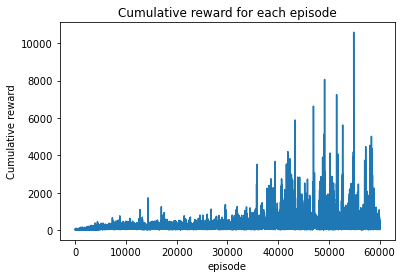

In [157]:
plt.plot(rewardArr)
print("Average cumulative reward:" + str(np.mean(rewardArr)))
print("Is my agent good enough? " + str(np.mean(rewardArr) > 195))

plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')

plt.show()

In [158]:
episode_reward = 0

env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
discrete_state = get_discrete_state(observation[0])

done = False
while not done:
    env.render()
    action = np.argmax(q_table[discrete_state])
    new_env = env.step(action)
    new_state = new_env[0]
    reward = new_env[1]
    done = new_env[2]
    episode_reward += reward
    
    new_discrete_state = get_discrete_state(new_state)
    discrete_state = new_discrete_state

    if done:
        observation = env.reset()
        discrete_state = get_discrete_state(observation[0])

env.close()
show_video()
print(episode_reward)

Could not find video
217.0
